In [1]:
import numpy as np
from matplotlib import image, pyplot as plt
import json
from celluloid import Camera

_ZI = np.complex(0, 1)

# Waves on an infinite string
We have to satisfy
\begin{align}
m_0 u_{tt} - \kappa_0 u_{xx} = 0\quad\textrm{for $x<0$},\\
m_1 u_{tt} - \kappa_1 u_{xx} = 0\quad\textrm{for $x>0$},\\
\kappa_0u_x(0^-) = \kappa_1u_x(0^+),\\
u(0^-) = u(0^+),\\
\end{align}
The governing equations are the wave equations
\begin{align}
&u_{tt} - c_i^2 u_{xx} = 0,\\
&c_i^2=\frac{\kappa_i}{m_i}.
\end{align}

## Time-harmonic solution
If $u(x,t) = \textrm{Re}\big[U(x)\textrm{e}^{-\textrm{i}\omega t}\big]$,
\begin{align}
&U_{xx} + k_i^2 U = 0,\\
&k_i^2=\frac{\omega^2}{c_i^2}=\frac{m_i\omega^2}{\kappa_i}.
\end{align}
The general solution is
\begin{align}
&U(x) = 
\begin{cases}
i^+\textrm{e}^{\textrm{i}k_0x} + s^+\textrm{e}^{-\textrm{i}k_0x} \quad\textrm{for $x<0$},\\
s^-\textrm{e}^{\textrm{i}k_1x} + i^-\textrm{e}^{-\textrm{i}k_1x} \quad\textrm{for $x>0$},
\end{cases}
\end{align}
with $i^\pm$ being (known) incident wave amplitudes and $s^\pm$ being (unknown) scattered wave amplitudes.
The boundary conditions imply that
\begin{align}
&i^+ + s^+ = i^- + s^-,\\
&\textrm{i}k_0(i^+ - s^+) = -\textrm{i}k_1(i^- - s^-),
\end{align}
so
\begin{align}
&\begin{pmatrix}
s^+ \\ s^-
\end{pmatrix} = 
\frac{1}{k_0+k_1}
\begin{pmatrix}
k_0 - k_1 & 2k_1 \\
2k_0 & k_1 - k_0
\end{pmatrix}
\begin{pmatrix}
i^+ \\ i^-
\end{pmatrix}
 = \begin{pmatrix}
R^+ & T^- \\
T^+ & R^-
\end{pmatrix}
\begin{pmatrix}
i^+ \\ i^-
\end{pmatrix}.
\end{align}
Note that the scattering is independent of wave period since $\omega$ factors in $k_0$ and $k_1$ cancel out.

## Energy conservation
\begin{align}
0&=\int_{-\infty}^\infty\big(
(U_{xx}+k_i^2U)U^*
-
(U^{*}_{xx}+k_i^2U^*)U
\big)\textrm{d}x\\
&=\big[U_xU^* - UU_x^*\big]^{\infty}_{-\infty}\\
&=2\textrm{i}k_1\big(|s^-|^2-|i^-|^2\big)
- 2\textrm{i}k_0\big(|i^+|^2-|s^+|^2\big)
\end{align}
Let $\alpha = {k_1}/{k_0}$. Then if $i^+=1$ and $i^-=0$, $|R^+|^2 + \alpha |T^+|^2 = 1$. Similarly, $|R^-|^2 + \alpha^{-1} |T^-|^2 = 1$.

## Properties of a segment of string

In [9]:
class StringProps:

    def __init__(self, m=1, kappa=4, period=3):
        """
        Class to manage string properties
        
        Parameters:
        -----------
        m : float
            mass per unit length (kg/m)
        kappa : float
            string stiffness (Pa/m)
        period : float
            wave period (s)
        """
        self.m = m
        self.kappa = kappa
        self.period = period


    @property
    def c(self):
        """
        Returns:
        --------
        c : float
            wave speed (m/s)
        """
        return np.sqrt(self.kappa/self.m)
    
    
    @property
    def omega(self):
        """
        Returns:
        --------
        omega : float
            radial wave frequency (1/s)
            = 2\pi/period
        """
        return 2*np.pi/self.period # 1/s


    @property
    def k(self):
        """
        Returns:
        --------
        k : numpy.array(float)
            wave frequency (1/m)
            = 2\pi/wavelength
        """
        return np.array([self.omega/self.c])

    
    @property
    def num_modes(self):
        """
        Returns:
        --------
        num_modes : int
            number of wave modes
        """
        return len(self.k)

    
    def get_displacement(self, x, a0, a1, x0=0, x1=0):
        """
        Calculate a displacement profile

        Parameters:
        -----------
        x : numpy.array(float)
            positions to evaluate the displacement
        a0 : numpy.array(float)
            wave amplitudes for waves travelling from left to right
        a1 : numpy.array(float)
            wave amplitudes for waves travelling from right to left
        x0 : float
            position generating waves from left
        x1 : float
            position generating waves from right

        Returns:
        --------
        u : numpy.array(float)
            complex displacement U evaluated at x
        """
        u = np.exp(_ZI*np.outer(x - x0, self.k)).dot(a0)  # (nx,nk) x (nk,1) = (nx,1)
        u += np.exp(_ZI*np.outer(x1 - x, self.k)).dot(a1) # (nx,nk) x (nk,1) = (nx,1)
        return u

## Scattering by a change in string properties

In [3]:
class StringBoundary:
    
    def __init__(self, seg_lhs, seg_rhs, position=0):
        """
        Class to calculate the scattering by a change in string properties
        
        Parameters:
        -----------
        seg_lhs : StringProperties
            object containing properties of the string segment to the left of the boundary
        seg_rhs : StringProperties
            object containing properties of the string segment to the right of the boundary
        position : float
            x value where the boundary occurs
        """
        self.seg_lhs = seg_lhs
        self.seg_rhs = seg_rhs
        self.position = position
        assert(self.seg_lhs.omega == self.seg_rhs.omega)


    @property
    def period(self):
        """
        Returns:
        --------
        period : float
            wave period (s)
        """
        return self.seg_lhs.period
    

    @property
    def omega(self):
        """
        Returns:
        --------
        omega : float
            radial wave frequency (1/s)
            = 2\pi/period
        """
        return self.seg_lhs.omega
    

    @property
    def intrinsic_admittance(self):
        """
        Returns:
        --------
        intrinsic_admittance : float
            coefficient \alpha in the conservation of energy equation
        """
        return self.seg_rhs.k[0]/self.seg_lhs.k[0]


    @property
    def xlim(self):
        """
        Returns:
        --------
        xlim : tuple
            left and right hand limits of scatterer
            (both are self.position for a sharp change in properties)
        """
        return self.position, self.position


    def solve(self):
        """
        Solve the boundary conditions to set the scattering matrices
        
        Sets:
        -----
        Rp_ : numpy.ndarray(float)
            R^+ matrix (reflection of waves to right)
        Rm_ : numpy.ndarray(float)
            R^- matrix (reflection of waves to left)
        Tp_ : numpy.ndarray(float)
            T^+ matrix (transmission of waves to right)
        Tm_ : numpy.ndarray(float)
            T^- matrix (transmission of waves to left)
        """
        k0 = self.seg_lhs.k[0]
        k1 = self.seg_rhs.k[0]
        fac = 1/(k0 + k1)
        self.Rp_ = fac*np.array([[k0-k1]])
        self.Tm_ = fac*np.array([[2*k1]])
        self.Tp_ = fac*np.array([[2*k0]])
        self.Rm_ = fac*np.array([[k1-k0]])


    def get_scattered_amplitudes(self, ip, im):
        """
        Get amplitudes of scattered waves

        Parameters:
        -----------
        ip : numpy.array(float)
            wave amplitudes of incident waves to right
        im : numpy.array(float)
            wave amplitudes of incident waves to left

        Returns:
        --------
        sp : numpy.array(float)
            wave amplitudes for waves scattered to left
        sm : numpy.array(float)
            wave amplitudes for waves scattered to right
        """
        sp = self.Rp_.dot(ip) + self.Tm_.dot(im) #x<0
        sm = self.Tp_.dot(ip) + self.Rm_.dot(im) #x>0
        return sp.flatten(), sm.flatten()


    def get_displacement(self, x, inc_amps=None):
        """
        Get displacement profile

        Parameters:
        -----------
        x : numpy.array(float)
            positions to evaluate the displacement
        inc_amps : list or tuple
            (ip,im) with
                ip : numpy.array(float)
                    wave amplitudes of incident waves to right
                im : numpy.array(float)
                    wave amplitudes of incident waves to left

        Returns:
        --------
        u : numpy.array(float)
            complex displacement U evaluated at x
        """
        if inc_amps is None:
            inc_amps = np.array([1]), np.array([0])
        ip, im = inc_amps
        u = np.zeros_like(x, dtype=np.complex)
        sp, sm = self.get_scattered_amplitudes(ip, im)
        for b, seg, a0, a1 in [
            (x>=0, self.seg_rhs, sm, im),
            (x<=0, self.seg_lhs, ip, sp),
            ]:
            u[b] = seg.get_displacement(
                x[b], a0, a1, x0=self.position, x1=self.position)
        return u
    
    
    def test_boundary_conditions(self):
        """
        Test boundary conditions are satisfied
        """
        ip, im = np.array([1]), np.array([0.5])
        sp, sm = self.get_scattered_amplitudes(ip, im)
        u_m = ip.sum() + sp.sum() #U(0^+)
        u_p = im.sum() + sm.sum() #U(0^-)
        assert(np.abs(u_m - u_p) < 1e-8)
        ux_m = _ZI*self.seg_lhs.k.dot(ip - sp)
        ux_p = _ZI*self.seg_rhs.k.dot(sm - im)
        assert(np.abs(ux_m - ux_p) < 1e-8)
        print("Boundary conditions are OK")
        print(f"u(0) = {u_m} = {u_p}")
        print(f"u_x(0) = {ux_m} = {ux_p}")


    def test_swap(self):
        """
        Test we get the expected results if the left-hand and right-hand string properties are swapped
        """
        swap = StringBoundary(self.seg_rhs, self.seg_lhs, position=self.position)
        swap.solve()
        assert(np.allclose(self.Rp_, swap.Rm_))
        assert(np.allclose(self.Tp_, swap.Tm_))
        assert(np.allclose(self.Rm_, swap.Rp_))
        assert(np.allclose(self.Tm_, swap.Tp_))
        print('Swap is OK')
        

    def test_energy(self):
        """
        Test energy is conserved
        """
        alp = self.intrinsic_admittance
        e = np.abs(self.Rp_[0,0])**2 + alp*np.abs(self.Tp_[0,0])**2
        assert(np.abs(e-1) < 1e-8)
        e = np.abs(self.Rm_[0,0])**2 + np.abs(self.Tm_[0,0])**2/alp
        assert(np.abs(e-1) < 1e-8)
        print('Energy is OK')
    

    def plot_displacement(self, ax=None, t=0, x=None, inc_amps=None, no_title=False, **kwargs):
        """
        Plot displacement profile

        Parameters:
        -----------
        t : float
            time (s)
        x : numpy.array(float)
            positions (m) to evaluate the displacement
        inc_amps : list or tuple
            (ip,im) with
                ip : numpy.array(float)
                    wave amplitudes of incident waves to right
                im : numpy.array(float)
                    wave amplitudes of incident waves to left
        kwargs for matplotlib.pyplot.plot

        Returns:
        --------
        ax : matplotlib.axes._subplots.AxesSubplot
            plot axis
        """
        if x is None:
            lam = 2*np.pi/np.max([self.seg_lhs.k.real, self.seg_rhs.k.real])
            fac = 2.5
            xp = np.linspace(0, fac*lam, int(fac*100))
            
        # calc displacement
        up = self.get_displacement(
            self.position + xp, inc_amps=inc_amps)*np.exp(-_ZI*self.omega*t)
        um = self.get_displacement(
            self.position - xp, inc_amps=inc_amps)*np.exp(-_ZI*self.omega*t)
        umax = 1.1*np.max([np.abs(up).max(), np.abs(um).max()])

        # plot it
        if ax is None:
            fig = plt.figure(figsize=(14,7))
            ax = fig.add_subplot(111)            
        ax.plot(self.position + xp, up.real, 'b', **kwargs)
        ax.plot(self.position - xp, um.real, 'r', **kwargs)
        if not no_title:
            ax.set_title(f"u at t={t}s")
        ax.set_xlabel("x, m")
        ax.set_ylabel("u, m")
        ax.set_xlim([-xp.max(), xp.max()])
        ax.set_ylim([-umax, umax])
        return ax


    def animate_displacement(self, figname='animation.gif', **kwargs):
        """
        make an animation of the displacement (saved to file)
        
        Parameters:
        -----------
        figname : str
        kwargs for StringBoundary.plot_displacement
        """
        tvec = np.linspace(0, self.period, 24)
        fig = plt.figure(figsize=(7,7))
        ax = fig.add_subplot(111)
        cam = Camera(fig)
        for t in tvec[:-1]:
            ax = self.plot_displacement(t=t, ax=ax, no_title=True, **kwargs)
            plt.pause(.1)
            cam.snap()
        anim = cam.animate()
        print(f'Saving {figname}')
        plt.close()
        anim.save(figname, fps=12)

## Example calculation
### Set string props to left and right of boundary

In [4]:
period = 4
seg_lhs = StringProps(m=2, period=period)
seg_rhs = StringProps(kappa = 13, period=period)

### Solve scattering  problem

In [5]:
bdy = StringBoundary(seg_lhs, seg_rhs)
bdy.solve()

### Run tests

In [6]:
bdy.test_boundary_conditions()
bdy.test_swap()
bdy.test_energy()

Boundary conditions are OK
u(0) = 1.7182709533097467 = 1.7182709533097467
u_x(0) = 0.31292229368093694j = 0.3129222936809368j
Swap is OK
Energy is OK


### Plot the displacement at a given time

<AxesSubplot:title={'center':'u at t=0.3s'}, xlabel='x, m', ylabel='u, m'>

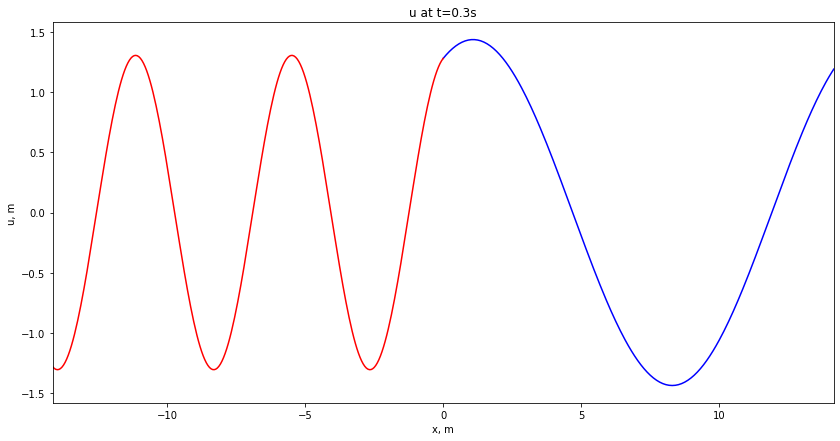

In [7]:
bdy.plot_displacement(t=0.3)

### Animate displacement

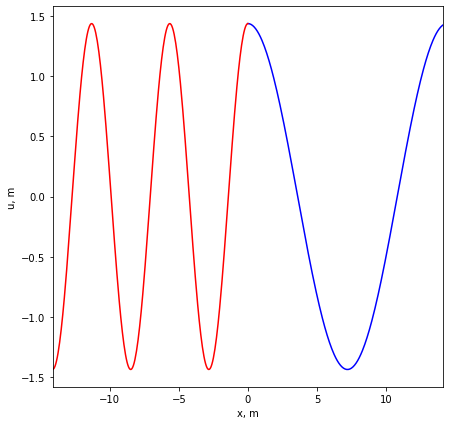

MovieWriter ffmpeg unavailable; using Pillow instead.


Saving animation.gif


In [8]:
out = 'animation.gif'
bdy.animate_displacement(out)

### Display animation of displacement
![SegmentLocal](animation.gif "segment")

## Multiple scattering
\begin{align}
&\textbf{s}^+ = \textbf{R}_0^+\textbf{i}^+
+ \textbf{T}_0^-\textbf{D}_{0}\textbf{b}_{0}\\
&\textbf{a}_0 = \textbf{T}_0^+\textbf{i}^+
+ \textbf{R}_0^-\textbf{D}_{0}\textbf{b}_{0}\\
&\textbf{a}_n = \textbf{T}_n^+\textbf{D}_{n-1}\textbf{a}_{n-1}
+ \textbf{R}_n^-\textbf{D}_{n}\textbf{b}_{n}\\
&\textbf{b}_n = \textbf{T}_{n+1}^-\textbf{D}_{n+1}\textbf{b}_{n+1}
+ \textbf{R}_{n+1}^+\textbf{D}_{n}\textbf{a}_{n}\\
&\textbf{b}_{N-1} = \textbf{T}_{N}^-\textbf{i}^-
+ \textbf{R}_{N}^+\textbf{D}_{N-1}\textbf{a}_{N-1}\\
&\textbf{s}^- = \textbf{R}_{N}^-\textbf{i}^-
+ \textbf{T}_{N}^+\textbf{D}_{N-1}\textbf{a}_{N-1}
\end{align}
Combining these gives
\begin{align}
&\textbf{a} = \textbf{B}^+\textbf{i}^+
+\textbf{A}_{00}\textbf{a}
+\textbf{A}_{01}\textbf{b}\\
&\textbf{b} = \textbf{B}^-\textbf{i}^-
+\textbf{A}_{10}\textbf{a}
+\textbf{A}_{11}\textbf{b},
\end{align}

where
\begin{align}
&\textbf{B}^+ = \begin{pmatrix}
\textbf{T}_0^+\\ \textbf{0} \\ \cdots \\  \textbf{0}
\end{pmatrix},
\quad
\textbf{B}^- = \begin{pmatrix}
\textbf{0} \\ \cdots \\  \textbf{0} \\ \textbf{T}_N^-
\end{pmatrix},
\\
&\textbf{A}_{00} = \begin{pmatrix}
\textbf{0}                     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{T}_1^+\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{T}_2^+\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{T}_{N-1}^+\textbf{D}_{N-2} & \textbf{0} \\
\end{pmatrix},
\quad
\textbf{A}_{01} = \begin{pmatrix}
\textbf{R}_0^-\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{R}_1^-\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{R}_{N-2}^-\textbf{D}_{N-2} & \textbf{0} \\
\textbf{0} & \textbf{0} & \cdots & \textbf{0} & \textbf{R}_{N-1}^-\textbf{D}_{N-1}
\end{pmatrix},\\
&\textbf{A}_{01} = \begin{pmatrix}
\textbf{R}_1^+\textbf{D}_0     & \textbf{0} & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{R}_2^+\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \cdots & \textbf{0}     & \textbf{R}_{N-1}^+\textbf{D}_{N-2} & \textbf{0} \\
\textbf{0} & \textbf{0} & \cdots & \textbf{0} & \textbf{R}_{N}^+\textbf{D}_{N-1}
\end{pmatrix},
\quad
\textbf{A}_{11} = \begin{pmatrix}
\textbf{0} & \textbf{T}_1^-\textbf{D}_1     & \textbf{0} & \cdots & \textbf{0} \\
\textbf{0} & \textbf{0} & \textbf{T}_2^-\textbf{D}_2 & \cdots & \textbf{0} \\
\cdots & \cdots & \cdots & \cdots & \cdots \\
\textbf{0} & \textbf{0}  &  \textbf{0}  & \cdots  & \textbf{T}_{N-1}^-\textbf{D}_{N-1} \\
\textbf{0} & \textbf{0} & \textbf{0} & \cdots & \textbf{0}
\end{pmatrix}.
\end{align}